# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [10]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



In [11]:
import requests 

resource_url = "http://books.toscrape.com/"

agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
headers = {"User-Agent": agent}

response = requests.get(resource_url, headers=headers)

response.status_code

200

In [12]:
len(response.content), response.content

(51294,
 b'<!DOCTYPE html>\n<!--[if lt IE 7]>      <html lang="en-us" class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->\n<!--[if IE 7]>         <html lang="en-us" class="no-js lt-ie9 lt-ie8"> <![endif]-->\n<!--[if IE 8]>         <html lang="en-us" class="no-js lt-ie9"> <![endif]-->\n<!--[if gt IE 8]><!--> <html lang="en-us" class="no-js"> <!--<![endif]-->\n    <head>\n        <title>\n    All products | Books to Scrape - Sandbox\n</title>\n\n        <meta http-equiv="content-type" content="text/html; charset=UTF-8" />\n        <meta name="created" content="24th Jun 2016 09:29" />\n        <meta name="description" content="" />\n        <meta name="viewport" content="width=device-width" />\n        <meta name="robots" content="NOARCHIVE,NOCACHE" />\n\n        <!-- Le HTML5 shim, for IE6-8 support of HTML elements -->\n        <!--[if lt IE 9]>\n        <script src="//html5shim.googlecode.com/svn/trunk/html5.js"></script>\n        <![endif]-->\n\n        \n            <link rel="shortcut 

In [13]:
soup = BeautifulSoup(response.content)
soup

<!DOCTYPE html>

<!--[if lt IE 7]>      <html lang="en-us" class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->
<!--[if IE 7]>         <html lang="en-us" class="no-js lt-ie9 lt-ie8"> <![endif]-->
<!--[if IE 8]>         <html lang="en-us" class="no-js lt-ie9"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js" lang="en-us"> <!--<![endif]-->
<head>
<title>
    All products | Books to Scrape - Sandbox
</title>
<meta content="text/html; charset=utf-8" http-equiv="content-type"/>
<meta content="24th Jun 2016 09:29" name="created"/>
<meta content="" name="description"/>
<meta content="width=device-width" name="viewport"/>
<meta content="NOARCHIVE,NOCACHE" name="robots"/>
<!-- Le HTML5 shim, for IE6-8 support of HTML elements -->
<!--[if lt IE 9]>
        <script src="//html5shim.googlecode.com/svn/trunk/html5.js"></script>
        <![endif]-->
<link href="static/oscar/favicon.ico" rel="shortcut icon"/>
<link href="static/oscar/css/styles.css" rel="stylesheet" type="text/css"/>
<link href="s

In [14]:
product = soup.find_all('article', class_='product_pod')
len(product), product[0]

(20,
 <article class="product_pod">
 <div class="image_container">
 <a href="catalogue/a-light-in-the-attic_1000/index.html"><img alt="A Light in the Attic" class="thumbnail" src="media/cache/2c/da/2cdad67c44b002e7ead0cc35693c0e8b.jpg"/></a>
 </div>
 <p class="star-rating Three">
 <i class="icon-star"></i>
 <i class="icon-star"></i>
 <i class="icon-star"></i>
 <i class="icon-star"></i>
 <i class="icon-star"></i>
 </p>
 <h3><a href="catalogue/a-light-in-the-attic_1000/index.html" title="A Light in the Attic">A Light in the ...</a></h3>
 <div class="product_price">
 <p class="price_color">£51.77</p>
 <p class="instock availability">
 <i class="icon-ok"></i>
     
         In stock
     
 </p>
 <form>
 <button class="btn btn-primary btn-block" data-loading-text="Adding..." type="submit">Add to basket</button>
 </form>
 </div>
 </article>)

In [15]:
ranking_map = {"One":1, "Two":2, "Three":3, "Four":4, "Five":5}
list_products = []

for product in product:
    
    product_title = product.find('h3').find('a')['title']

    product_price = product.find('p', class_='price_color')
    product_price_float = float(product_price.text[1:])

    ranking = product.find('p', class_='star-rating')
    ranking_work = ranking.get('class')
    rating = 0
    for foo in ranking_work:              
        if foo in ranking_map:            
            rating = ranking_map[foo]     
            break
    list_products.append({"title": product_title, "price":product_price_float, "ranking": rating})


list_products[:5], len(list_products)

([{'title': 'A Light in the Attic', 'price': 51.77, 'ranking': 3},
  {'title': 'Tipping the Velvet', 'price': 53.74, 'ranking': 1},
  {'title': 'Soumission', 'price': 50.1, 'ranking': 1},
  {'title': 'Sharp Objects', 'price': 47.82, 'ranking': 4},
  {'title': 'Sapiens: A Brief History of Humankind',
   'price': 54.23,
   'ranking': 5}],
 20)

In [16]:
df = pd.DataFrame(list_products)
df

,title,price,ranking
0,A Light in the Attic,51.77,3
1,Tipping the Velvet,53.74,1
2,Soumission,50.10,1
3,Sharp Objects,47.82,4
4,Sapiens: A Brief History of Humankind,54.23,5
5,The Requiem Red,22.65,1
6,The Dirty Little Secrets of Getting Your Dream...,33.34,4
7,The Coming Woman: A Novel Based on the Life of...,17.93,3
8,The Boys in the Boat: Nine Americans and Their...,22.60,4
9,The Black Maria,52.15,1


/tmp/ipykernel_2030/1300643369.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y='title', x='ranking', palette='rainbow')


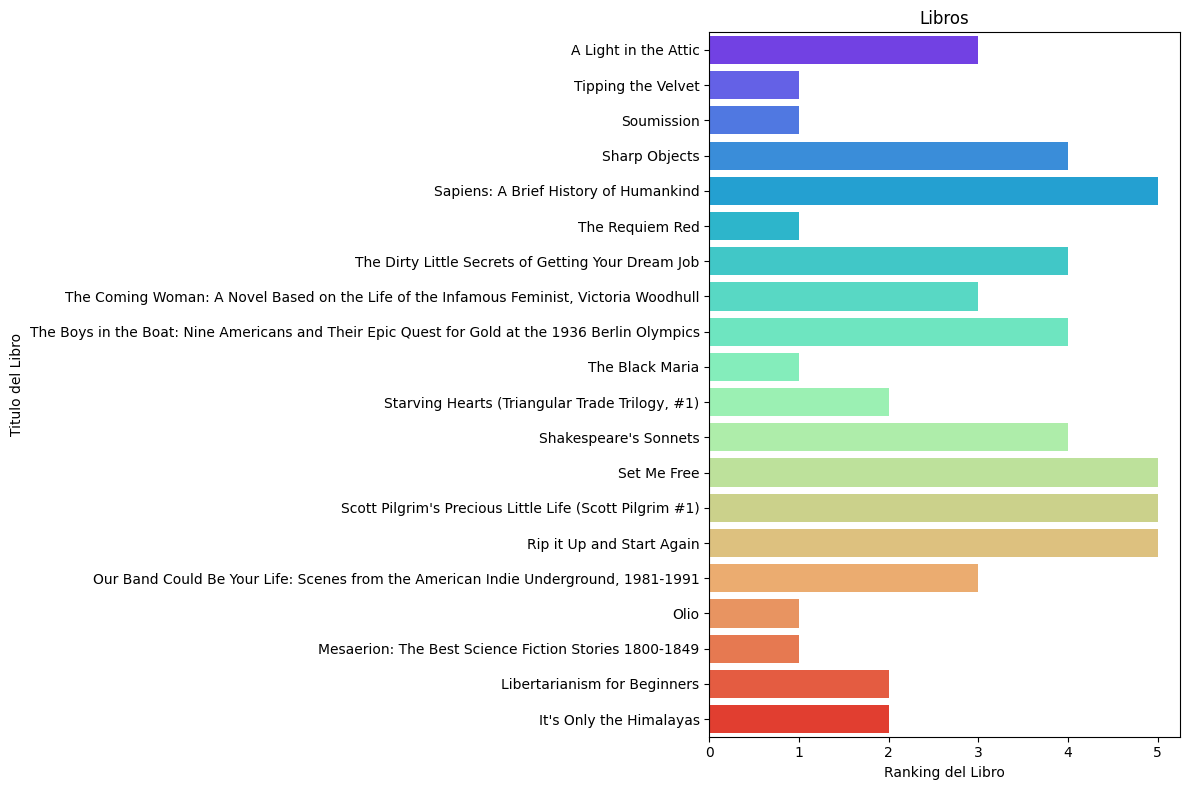

In [17]:
plt.figure(figsize=(12,8))
sns.barplot(data=df, y='title', x='ranking', palette='rainbow')


plt.title('Libros')
plt.xlabel('Ranking del Libro')
plt.ylabel('Titulo del Libro')
plt.tight_layout()
plt.show()
